In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

data = pd.read_csv('inningScore.csv') 
print(data.head())

print(data.columns)

  Team  1  2  3  4  5  6  7  8  9  ...  10  11  12  13  14  15  16  17  18  19
0  STL  0  0  0  0  0  0  0  0  1  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
1  PIT  0  2  0  0  0  1  0  1  -  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2  TOR  2  0  0  1  0  0  0  2  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
3   TB  0  0  1  0  0  0  0  0  2  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
4  NYM  0  0  0  0  0  0  0  3  0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN

[5 rows x 24 columns]
Index(['Team', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'R', 'H', 'E',
       'Game', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
      dtype='object')


In [55]:
To_which_inning = 5

def Sum_to_n_inning(To_which_inning: int):  
    # sum from 1st inning to 5th inning for every row
    col_list = [str(i) for i in range(1, To_which_inning+1)]

    # Convert columns to numeric type
    data[col_list] = data[col_list].apply(pd.to_numeric, errors='coerce')   

    data['InningSum'] = data[col_list].sum(axis=1, numeric_only=True)
    sum_data = data[['Team', 'Game', 'InningSum']].copy()

    # print(sum_data.head(10))

    # For every Game, calculate the abs difference between the two teams 
    # One Game print out one row
    # x.diff(): home - away (lower row minus upper row)
    sum_data.loc[:, 'SumDiff'] = sum_data.groupby('Game')['InningSum'].transform(lambda x: x.diff())

    # only print distinct Game
    diff_data = sum_data[['Game', 'SumDiff']]
    diff_data = diff_data.dropna()
    # print(diff_data.head())

    plt.title(f'SumDiff to the end of Inning {To_which_inning}')
    sns.histplot(diff_data['SumDiff'], bins=20, kde=True)


def neg_sum_to_n_inning(To_which_inning: int) -> pd.Series:  
    # sum from 1st inning to 5th inning for every row
    col_list = [str(i) for i in range(1, To_which_inning+1)]

    # Convert columns to numeric type
    data[col_list] = data[col_list].apply(pd.to_numeric, errors='coerce')   

    data['InningSum'] = data[col_list].sum(axis=1, numeric_only=True)
    sum_data = data[['Team', 'Game', 'InningSum']].copy()

    # print(sum_data.head(10))

    # For every Game, calculate the abs difference between the two teams 
    # One Game print out one row
    # x.diff(): home - away (lower row minus upper row)
    sum_data.loc[:, 'SumDiff'] = sum_data.groupby('Game')['InningSum'].transform(lambda x: x.diff())

    # only print distinct Game
    diff_data = sum_data[['Game', 'SumDiff']]
    diff_data = diff_data.dropna()
    neg_diff_data = diff_data[diff_data['SumDiff'] <= 0]

    return neg_diff_data

## Plot the run difference to the end of inning 1-8

In [56]:
# # Create subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

# neg_diff_data_list = []
# for i, ax in enumerate(axs.flat, start=1):
#     plt.subplot(2, 4, i)  # Set current subplot
#     diff_data = Sum_to_n_inning(i)

# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

## Get the run difference to the end of inning 1-8 (only negative results)

In [57]:
neg_diff_data_list = []
for i in range(1, 9):
    neg_diff_data = neg_sum_to_n_inning(i)
    neg_diff_mean = neg_diff_data['SumDiff'].mean()
    print(f'(negative) mean diff. at {i}-th inning: {neg_diff_mean}')
    neg_diff_data_list.append(neg_diff_data)

neg_diff_data_list[0].shape

(negative) mean diff. at 1-th inning: -0.5327877134485197
(negative) mean diff. at 2-th inning: -0.9769195082347483
(negative) mean diff. at 3-th inning: -1.4262958280657396
(negative) mean diff. at 4-th inning: -1.7850219094409774
(negative) mean diff. at 5-th inning: -2.138078783690394
(negative) mean diff. at 6-th inning: -2.4323063877897115
(negative) mean diff. at 7-th inning: -2.711158798283262
(negative) mean diff. at 8-th inning: -2.9945031100824533


(9897, 2)

## Run difference at the End of the Game

(13450, 2)
ScoreDiff
 1.0     2200
-1.0     1489
 2.0     1245
-2.0     1152
 3.0      992
-3.0      949
 4.0      806
-4.0      762
-5.0      578
 5.0      574
 6.0      410
-6.0      406
 7.0      315
-7.0      306
 8.0      217
-8.0      193
 9.0      148
-9.0      142
 10.0      98
-10.0      95
-11.0      63
 11.0      60
 12.0      41
-12.0      35
 13.0      33
-13.0      32
 14.0      23
-14.0      17
-15.0      14
 15.0      10
 0.0        8
 16.0       8
-16.0       5
 18.0       4
 17.0       4
-18.0       3
-17.0       3
-19.0       2
 19.0       2
 21.0       2
 20.0       2
-20.0       1
-21.0       1
Name: count, dtype: int64


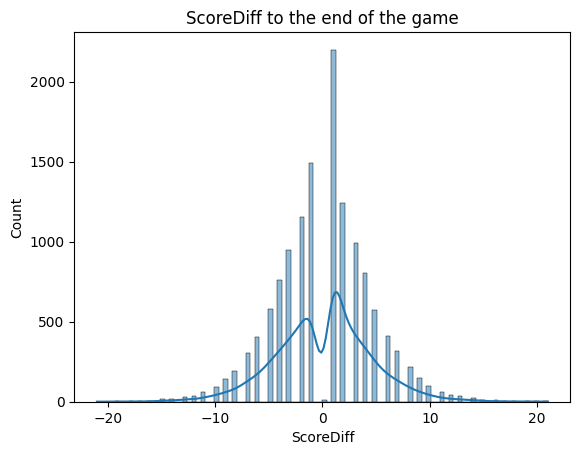

In [58]:
# sum elements in all_inning if it is not NaN
all_inning = [str(i) for i in range(1, 20)]
# print(all_inning)

data[all_inning] = data[all_inning].replace({np.nan: 0, '-': 0})

# Convert columns to numeric type
data[all_inning] = data[all_inning].apply(pd.to_numeric, errors='coerce')

data["final_score"] = data[all_inning].sum(axis=1, numeric_only=True)

# calculate the difference between the two teams per game
data['ScoreDiff'] = data.groupby('Game')['final_score'].transform(lambda x: x.diff())

# print(data.head())

ScoreDiff_data = data[['Game', 'ScoreDiff']].dropna()

print(ScoreDiff_data.shape)
print(ScoreDiff_data['ScoreDiff'].value_counts())

plt.title('ScoreDiff to the end of the game')
sns.histplot(ScoreDiff_data['ScoreDiff'], bins=100, kde=True)

plt.show()

## Divide final run differences with the $k$-th inning results (inning 1 ~ 8)

In [59]:
score_diff_data_set = []
for i in range(8):
    score_diff_data_set.append(ScoreDiff_data[ScoreDiff_data['Game'].isin(neg_diff_data_list[i]['Game'])])
    score_diff_mean = score_diff_data_set[i]['ScoreDiff'].mean()
    # print(score_diff_data_set[i])
    print('score diff mean: ', score_diff_mean)
    print('sample size:', score_diff_data_set[i].shape[0])

score_diff_data_set[0].head(5)

score diff mean:  -0.5575739226965385
sample size: 9909
score diff mean:  -1.055812876331635
sample size: 8636
score diff mean:  -1.5129337539432177
sample size: 7925
score diff mean:  -1.9738899933730947
sample size: 7545
score diff mean:  -2.322620689655172
sample size: 7250
score diff mean:  -2.6360817477096545
sample size: 7095
score diff mean:  -2.891108891108891
sample size: 7007
score diff mean:  -3.112730946882217
sample size: 6928


,Game,ScoreDiff
1,360403123,3.0
3,360403130,-2.0
9,360404101,1.0
11,360404113,1.0
13,360404115,-1.0


## Calculate confidence intervals (t-test)

In [60]:
from scipy import stats

confidence = 0.95
for i in range(8):
    lower, upper = stats.t.interval(
        confidence=confidence,
        df=score_diff_data_set[i].shape[0] - 1,
        loc=score_diff_data_set[i]['ScoreDiff'].mean(),
        scale=stats.sem(score_diff_data_set[i]['ScoreDiff'])
    )
    print(f'CI of final run difference (for {i + 1}-th inning): ({lower:.3f}, {upper:.3f})')

CI of final run difference (for 1-th inning): (-0.643, -0.472)
CI of final run difference (for 2-th inning): (-1.145, -0.967)
CI of final run difference (for 3-th inning): (-1.602, -1.424)
CI of final run difference (for 4-th inning): (-2.061, -1.887)
CI of final run difference (for 5-th inning): (-2.407, -2.238)
CI of final run difference (for 6-th inning): (-2.717, -2.555)
CI of final run difference (for 7-th inning): (-2.968, -2.814)
CI of final run difference (for 8-th inning): (-3.186, -3.039)


## Goodness-of-fit

There are four goodness-of-fit tests against differnet distributions:
1. Normal
2. Poisson
3. Exponential
4. Bimodal (located in `bimodal_distribution_test.py`)
5. Folded normal

In [61]:
'''
Preform normality test on ScoreDiff
'''
from scipy import stats

data = ScoreDiff_data['ScoreDiff']
stat, p_val = stats.kstest(data, 'norm', [data.mean(), data.std()])
print(f'mean: {data.mean()}; variance: {data.var()}')
if p_val > 0.05:
    print('normally distributed')
else:
    print('not normally distributed')

mean: 0.12973977695167285; variance: 20.438739243751904
not normally distributed


In [65]:
'''
Try test for Poisson or Exponential (with abs(x.diff())).
Since the mean and variance of our data is not close, it is unlikely a Poisson distribution.
Same reason for the exponential distribution.
'''


abs_data = abs(data)
# The mean and the variance are not close.
# That is, the underlying distribution is unlikely Poisson
print(f'mean: {abs_data.mean()}; variance: {abs_data.var()}')


scale = 1 / abs_data.mean()
stat, p_val = stats.kstest(abs_data, stats.expon.cdf, [0, scale])
if p_val > 0.05:
    print('exponentially distributed')
else:
    print('not exponentially distributed')

mean: 3.5749442379182157; variance: 7.674396327472558
not exponentially distributed


estimated param: (1.49696250296116, 0, 2.1878468639354858)


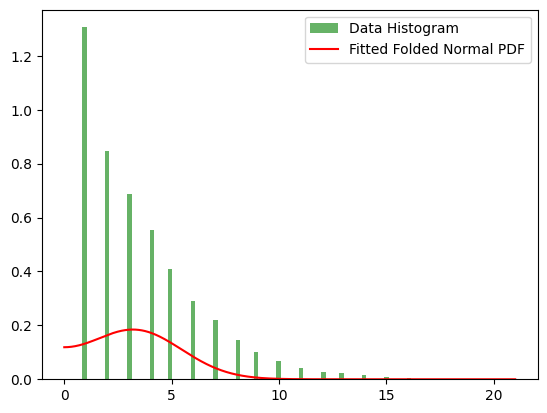

Kolmogorov-Smirnov Test: D=0.504852537420768, p-value=0.0
Reject the null hypothesis: The data does not follow the folded normal distribution.


In [63]:
"""
Test whether our data fits "folded normal distribution".

It turns out that the result is NO.
"""

# Plot histogram of the data
plt.hist(abs_data, bins=100, density=True, alpha=0.6, color='g', label='Data Histogram')

# Fit the data to a folded normal distribution
param = stats.foldnorm.fit(data, floc=0)

print(f'estimated param: {param}')

# Get the PDF of the fitted folded normal distribution
x = np.linspace(0, max(data), 1000)
pdf_fitted = stats.foldnorm.pdf(x, *param)
plt.plot(x, pdf_fitted, 'r-', label='Fitted Folded Normal PDF')

plt.legend()
plt.show()

# Kolmogorov-Smirnov Test
D, p_value_ks = stats.kstest(data, 'foldnorm', args=param)
print(f'Kolmogorov-Smirnov Test: D={D}, p-value={p_value_ks}')

# Interpretation
alpha = 0.05  # Common significance level
if p_value_ks > alpha:
    print("Fail to reject the null hypothesis: The data follows the folded normal distribution.")
else:
    print("Reject the null hypothesis: The data does not follow the folded normal distribution.")